In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d, median_filter

from vision.tools.camera import find_gl_by_percentile, plot_img, plot_two_img
from vision.depth.slicer.slicer import get_grad, get_search_limits, find_best_routh, slice_frame
from vision.depth.slicer.slicer import find_tree_height_limits, find_local_minimum, remove_windows





Bad key "text.kerning_factor" on line 4 in
/home/yotam/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
def plot_img_and_line(img, x1, y1, x2=None, y2=None):
    f, ax = plt.subplots(1, 1, figsize=(15, 10))
    ax.imshow(img)
    ax.plot(x1, y1, 'b')
    if x2 is not None and y2 is not None:
        ax.plot(x2, y2, 'r')

In [3]:
f_id = 271
fp = f"/home/yotam/FruitSpec/Sandbox/slicer_test/caracara_R2_3011/sliced3/depth/depth_frame_{f_id}.jpg"
depth = cv2.imread(fp)
depth = cv2.cvtColor(depth, cv2.COLOR_BGR2GRAY)
fp = f"/home/yotam/FruitSpec/Sandbox/slicer_test/caracara_R2_3011/sliced3/frames/frame_{f_id}.jpg"
frame = cv2.imread(fp)
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

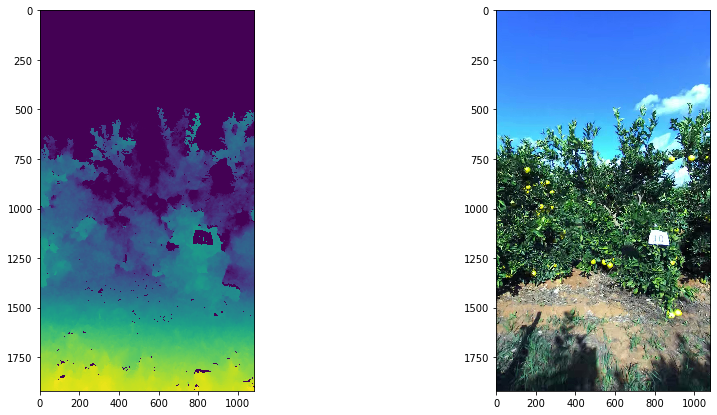

In [4]:
plot_two_img(depth, frame)

[430, 489, 510, 564, 589, 927]


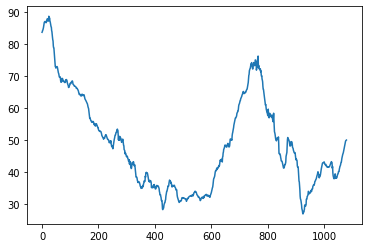

In [5]:
s, e = find_tree_height_limits(depth)

cropped_depth = depth[s:e, :].copy()
v = np.mean(cropped_depth, axis=0)
vec = find_local_minimum(cropped_depth)
plt.plot(v)
print(vec)



In [6]:
i =0
signal_thrs=10
window_thrs=0.75
end = e
start = s
final = []
mid = (start + end) // 2
index_ = vec[i]
# seperate the signal to two halfs
uppper_signal_vec = depth[start:mid, index_].copy()
lower_signal_vec = depth[mid: end, index_].copy()

# how many below threshold - no signal
upper = np.sum(uppper_signal_vec < signal_thrs) / (mid - start)
lower = np.sum(lower_signal_vec < signal_thrs) / (end - mid)
print(f'upper {upper}')
print(f'lower {lower}')

if upper > window_thrs and lower > window_thrs:
    # valid
    final.append(index_)
elif upper > window_thrs and lower < window_thrs:
    
    print('upper window')
elif upper < window_thrs and lower > window_thrs:
    print('lower window')
else: # gap - valid
    final.append(index_)


upper 0.6446078431372549
lower 0.2078239608801956


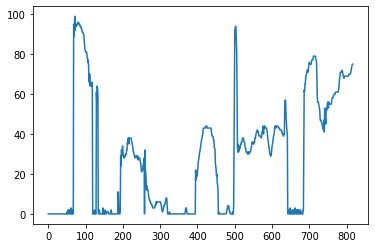

In [7]:
plt.plot(depth[start:e, index_])

In [8]:
f = remove_windows(depth, vec, s, e, window_thrs=0.70)

In [9]:
f

[430, 489, 510, 927]

In [22]:
#output = frame.copy()
last= f[0]
neighbours = [last]
reduced = []
for i in f[1:]:
    if i - neighbours[-1] < 150:
        print('close')
        neighbours.append(i)
        print(neighbours)
    else:
        score = np.array([])
        for n in neighbours:
            score = np.append(score, np.sum(depth[s:e,n]))
        j = np.argmin(score)
        reduced.append(neighbours[j])
        
        neighbours = [i]
        print('far')
        print(neighbours)
        if i == f[-1]: # last
            reduced.append(i)
        
    #output = cv2.line(output, (i+1, s), (i+1, e), (255, 0, 255), 2)
#output = cv2.line(output, (f[1], s), (f[1], e), (255, 0, 255), 2)
print(reduced)

close
[430, 489]
close
[430, 489, 510]
far
[927]
[430, 927]


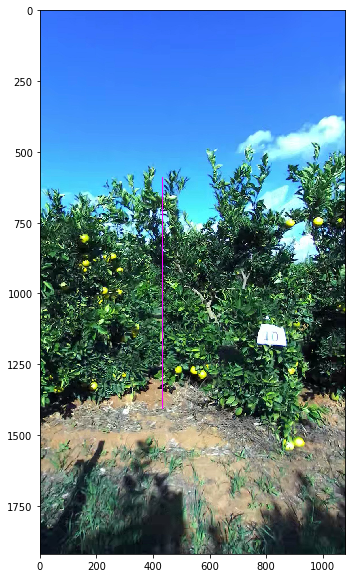

In [25]:
output = frame.copy()
for i in reduced:
    output = cv2.line(output, (i+1, s), (i+1, e), (255, 0, 255), 2)
plot_img(output)